# Generating Land Surface Temperature from multispectral imagery using Pix2Pix
> * 🔬 Data Science
> * 🥠 Deep Learning and image translation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export image domain data](#Export-image-domain-data)
* [Methodology](#Methodology)
* [Model training](#Model-training)
  * [Prepare data](#Prepare-data)
  * [Load Pix2Pix model architecture](#Load-Pix2Pix-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results in validation set](#Visualize-results-in-validation-set)
  * [Save the model](#Save-the-model)
  * [Compute evaluation metrics](#Compute-evaluation-metrics)
* [Model inferencing](#Model-inferencing)
  * [Generate raster using classify pixels using deep learning tool](#Generate-raster-using-classify-pixels-using-deep-learning-tool)
* [Results visualization](#1)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

Land Surface Temperature (LST) plays an important role in the Earth’s climate system. It represents the process of energy exchange, water content and affects the vegetation growth rate. Traditionally, LST from Landsat-8 is calculated using a chain of formulas, which is complex and demanding in terms of resources. Deep learning models provide an efficient way to compute and predict LST. In this study we propose an approach to predict LST from Landsat 8 imagery using [Pix2Pix](https://developers.arcgis.com/python/guide/how-pix2pix-works/) deep learning model. The LST was computed on a thermal band (band 10) from a single Landsat 8 imagery. The calculated LST was then used to train an image translation Pix2Pix model. The model is capable of translating Landsat-8 multispectral imagery to LST. The predictions can be used for multitemporal monitoring of LST.

## Necessary imports

In [2]:
import os
from pathlib import Path

from arcgis import GIS
from arcgis.learn import Pix2Pix, prepare_data

 ## Connect to your GIS

In [3]:
gis = GIS('home')

## Export image domain data

A stacked raster of Landsat-8 bands was created using band 1-7 and band 10. This mosaic will be used as `input_raster` for the training data.

<Item title:"landsat_mosaic" type:Imagery Layer owner:api_data_owner>
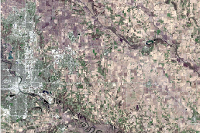

In [4]:
landsat_mosaic = ent_gis.content.get('19da58d93e03400fa616bf90e5ca0a01')
landsat_mosaic

The raster for Land Surface Temperature is generated using thermal band (band 10). This raster will be used as the `Additional Input Raster` for the training data.

<Item title:"lst_raster" type:Imagery Layer owner:api_data_owner>
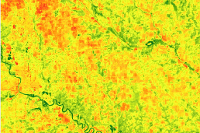

In [5]:
lst_raster = ent_gis.content.get('9ad85a611832495fa94b4737035d8bea')
lst_raster

## Methodology

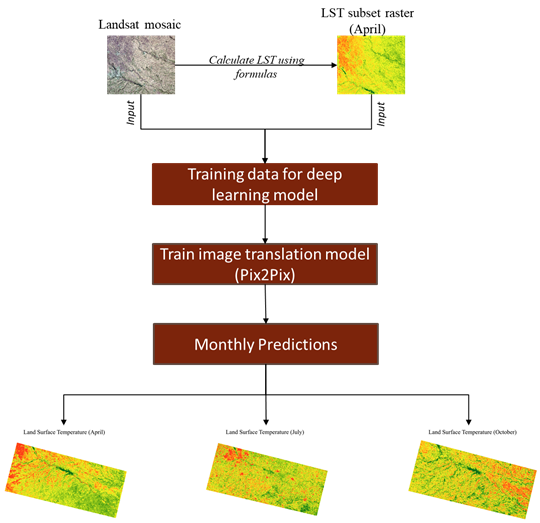

The above diagram encapsulates the overall methodology that has been followed in the estimation of the Land Surface Temperature from multispectral imagery using deep learning.

The data will be exported in “Export_Tiles” metadata format which is available in the [Export Training Data For Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool. This tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). The various inputs required by the tool, are described below.

- `Input Raster`: landsat_composite_raster

- `Additional Input Raster`: lst_raster

- `Tile Size X & Tile Size Y`: 256

- `Stride X & Stride Y`: 128

- `Meta Data Format`: 'Export_Tiles' as we are training a `Pix2Pix` model.

- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

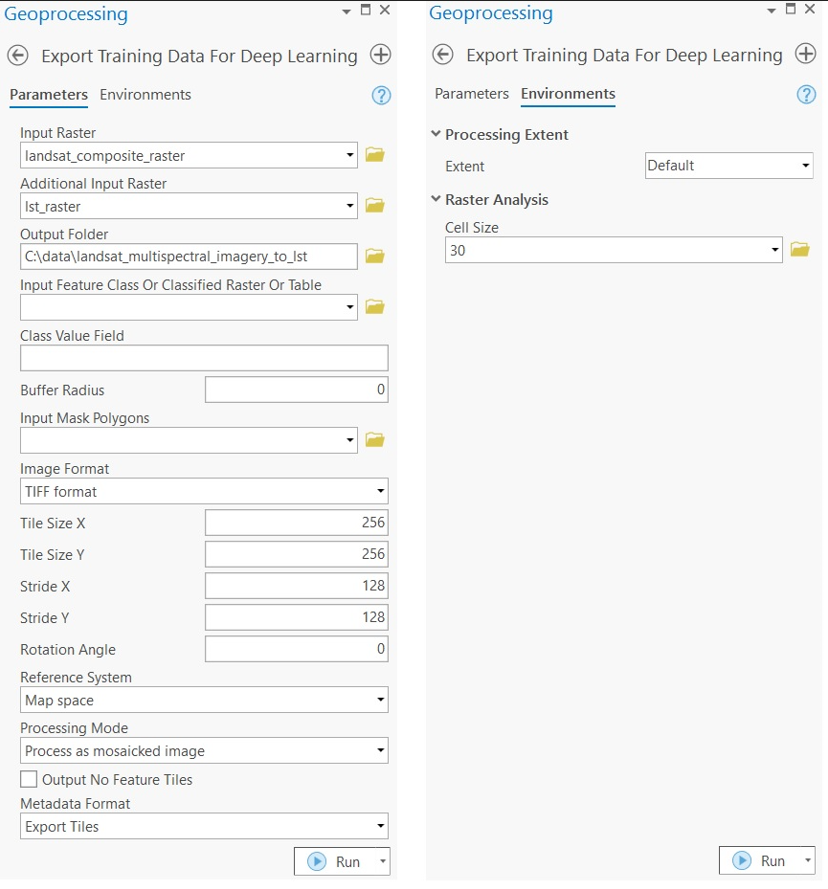

Inside the exported data folder, 'Images' and 'Images2' folders contain all the image tiles from two domains exported from `lansat_composite_raster` and `lst_raster` respectively.

## Model training

Alternatively, we have provided a subset of training data containing a few samples that follows the same directory structure mentioned above and also provided the rasters used for exporting the training dataset. The provided data can be used directly to run the experiments.

In [4]:
training_data = gis.content.get('11ebeb485c2d44898b32b91b105f8de6')
training_data

<Item title:"generating_lst_from_multispectral_imagery_using_pix2pix" type:Image Collection owner:demos_deldev>

In [6]:
filepath = training_data.download(file_name=training_data.name)

In [7]:
#Extract the data from the zipped image collection
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

### Prepare data

In [8]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [ ]:
data = prepare_data(output_path, dataset_type="Pix2Pix", batch_size=8)

In [ ]:
data

### Visualize a few samples from your training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them. On the left are some Landsat-8 rasters with the corresponding LST rasters (Land Surface Temperature) of various locations on the right.

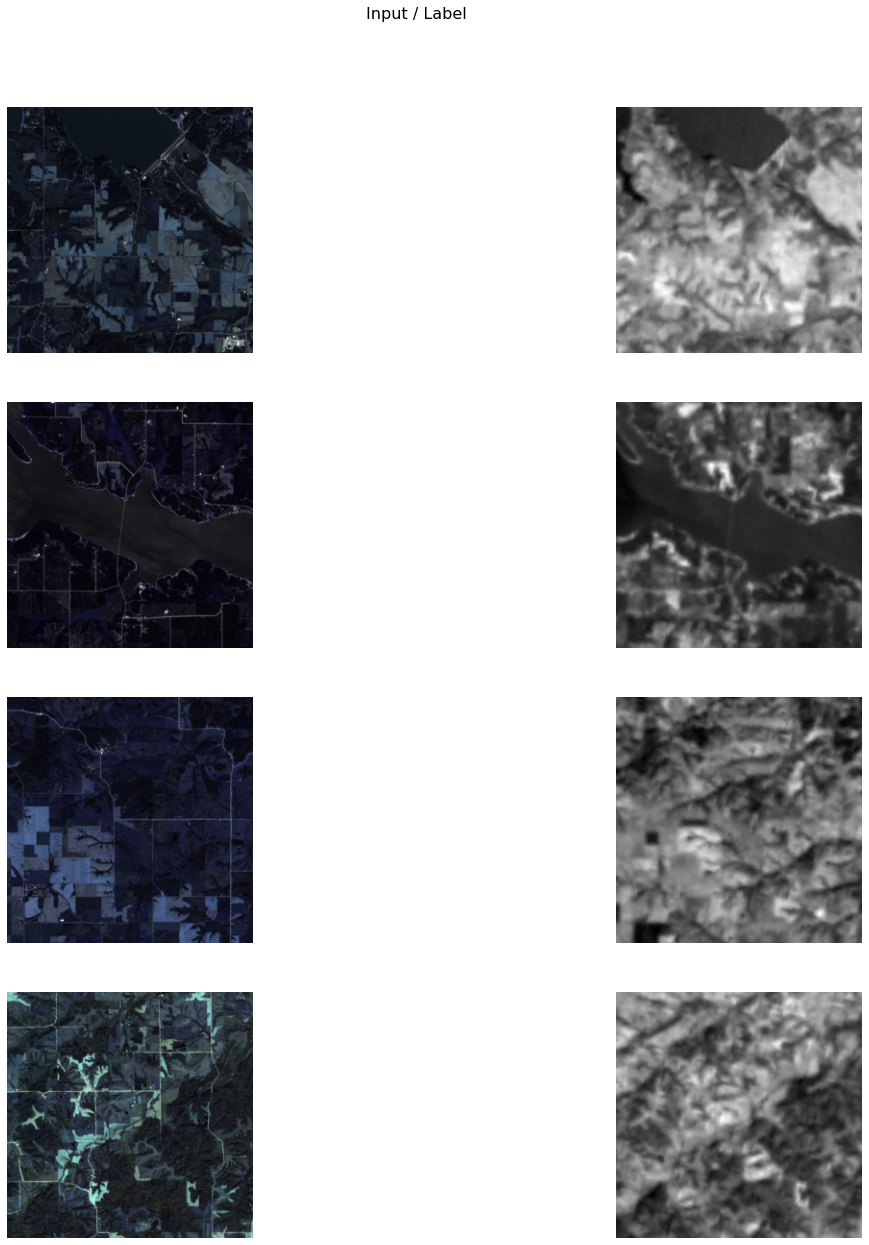

In [7]:
data.show_batch()

### Load model architecture

In [11]:
model = Pix2Pix(data)

### Tuning for optimal learning rate

Learning rate is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

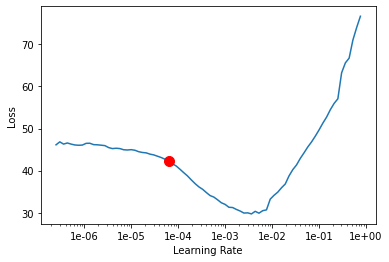

6.309573444801929e-05

In [8]:
lr = model.lr_find()
lr

### Fit the model

The model is trained for around a few epochs with the suggested learning rate.

In [9]:
model.fit(30, lr)

epoch,train_loss,valid_loss,gen_loss,l1_loss,D_loss,time
0,35.566357,30.796040,0.663380,0.349030,0.717529,01:05
1,19.291725,12.093425,0.622104,0.186696,0.742149,01:08
2,11.148993,8.225349,0.592061,0.105569,0.758912,01:11
3,7.698595,6.032180,0.579509,0.071191,0.764611,01:13
4,5.424048,3.987901,0.581081,0.048430,0.762080,01:12
5,3.604111,3.223908,0.593590,0.030105,0.753615,01:13
6,2.858333,2.664019,0.600027,0.022583,0.749187,01:14
7,2.528771,2.296279,0.604608,0.019242,0.746166,01:13
8,2.322142,2.211593,0.607804,0.017143,0.743662,01:13
9,2.194105,2.021927,0.608942,0.015852,0.742633,01:13


Here, with 30 epochs, we can see reasonable results — both training and validation losses have gone down considerably, indicating that the model is learning to translate between domain of imageries.

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. 

We will use the save() method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [11]:
model.save("pix2pix_lst_e30", publish=True)

Computing model metrics...


WindowsPath('C:/data/2021/lst_deeplearning/l8_lst_256px_128strd_30m/models/pix2pix_lst_e30')

### Visualize results in validation set

It is a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

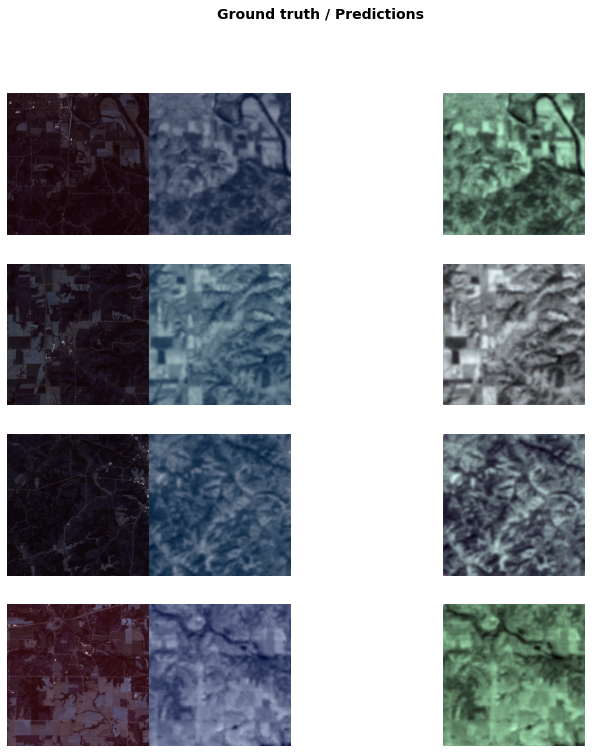

In [21]:
model.show_results(rows=4)

### Compute evaluation metrics

To objectively assess the synthesized image quality, obtained from the model generators, we quantitatively evaluated using `Structural Similarity (SSIM) Index`, and the `Peak Signal-to-Noise Ratio (PSNR)`.

The SSIM index measures the structural information similarity between images, where 0 indicates no similarity and 1 indicates complete similarity. The `SSIM value` for the trained model is `0.94`.

The PSNR measures image distortion and noise level between images, a 20 dB or higher PSNR indicates that the image is of good quality. The `PSNR value` for the trained model is `20.9`.

In [22]:
model.compute_metrics()

{'PSNR': '2.0965e+01', 'SSIM': '9.4536e-01'}

## Model inferencing

After we trained the `Pix2Pix` model and saved the weights for translating image and we could use the [Classify Pixels Using Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) tool, avialable in both `ArcGIS pro` and `ArcGIS Enterprise` for inferencing at scale. 

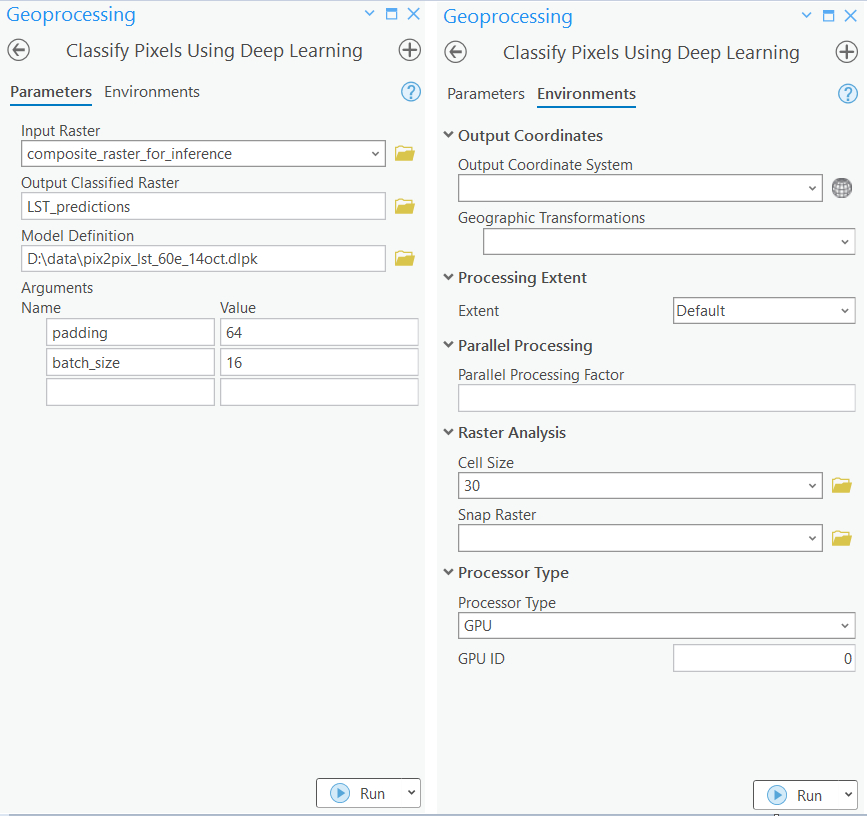

`with arcpy.EnvManager(processorType="GPU"): out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("composite_raster_for_inferencing", r"C:\path\to\model.dlpk", "padding 64;batch_size 8;predict_background True; tile_size 224", "PROCESS_AS_MOSAICKED_IMAGE", None); out_classified_raster.save(r"C:\sample\sample.gdb\predicted_lst")`

## Results visualization<a class="anchor" id="1"></a>

The LST for the months of April and July are generated using ArcGIS Pro. The output rasters are published on the portal for visualization. 

In [25]:
inferenced_results_april = ent_gis.content.search('April LST Prediction')[0]
inferenced_results_april

<Item title:"April LST Predictions" type:Imagery Layer owner:admin>

In [ ]:
inf_apr_lyr = extract_band(inferenced_results_april.layers[0], [1])
stretch_rs_apr = colormap(stretch(inf_apr_lyr, 
                                  stretch_type='PercentClip', 
                                  min=0, 
                                  max=255),
                          colormap_name="Condition Number")

In [44]:
inferenced_results_july = ent_gis.content.search('July LST Predictions')[0]
inferenced_results_july

<Item title:"July LST Predictions" type:Imagery Layer owner:admin>

In [ ]:
inf_july_lyr = extract_band(inferenced_results_july.layers[0], [1])
stretch_rs_july = colormap(stretch(inf_july_lyr, 
                                  stretch_type='PercentClip', 
                                  min=0, 
                                  max=255),
                          colormap_name="Condition Number")

### Create map widgets
Two map widgets are created showing Landsat 8 mosaic and Inferenced LST raster. 

In [23]:
map1 = ent_gis.map('Iowa, USA', 13)
map1.add_layer(stretch_rs_apr)
map2 = ent_gis.map('Iowa, USA', 13)
map2.add_layer(stretch_rs_july)
map3 = ent_gis.map('Iowa, USA', 13)
map3.basemap = 'satellite'map1.zoom_to_layer(stretch_rs_apr)

### Synchronize web maps

The maps are synchronized with each other using [MapView.sync_navigation](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. It helps in comparing the inferenced results with the DSM. Detailed description about advanced map widget options can be referred [here](https://developers.arcgis.com/python/guide/advanced-map-widget-usage/).

In [60]:
map1.sync_navigation(map2)
map2.sync_navigation(map3)

### Set the map layout

In [25]:
from ipywidgets import HBox, VBox, Label, Layout

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [26]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1,hb2,hb3=HBox([Label('April')]),\
            HBox([Label('July')]),\
            HBox([Label('RGB Imagery')])
hb1.layout,hb2.layout,hb3.layout=hbox_layout,hbox_layout,hbox_layout

### Results

The predictions are provided as a map for better visualization.

In [27]:
VBox([hb1,HBox([map1]),hb2,HBox([map2]), hb3,HBox([map3])])

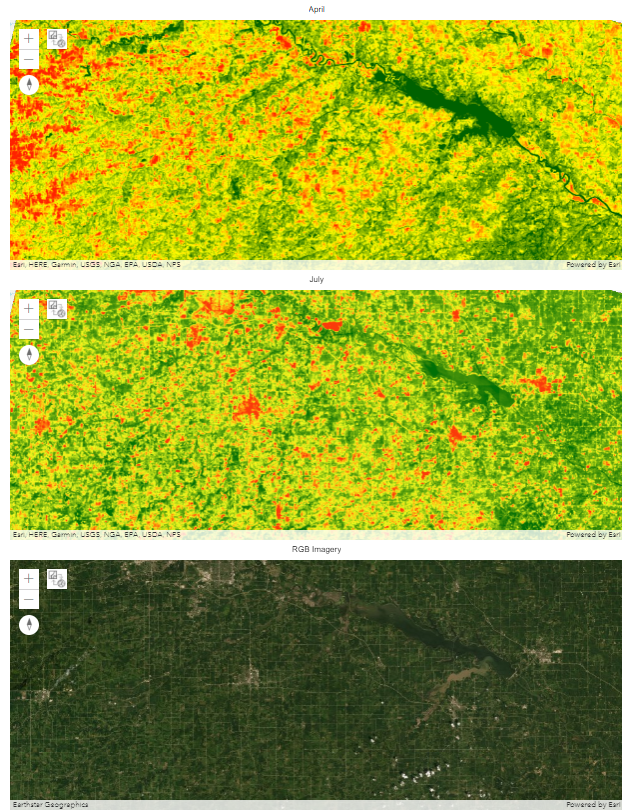

In [28]:
map2.zoom_to_layer(stretch_rs_apr)

In the above maps the landsurface temperature increases from dark green to red. The corn crop is usually sown in late April or early May, which means in the month of April which means there will be no or very less crop in this month. This can be seen in April's prediction that most of the area is in yellow or orange colour which means high land surface temperature. Whereas in the month of July, crop is fully grown and it can also be seen in the predictions that most of the area is dark or light green colour.

## Conclusion

In this notebook, we demonstrated how to use `Pix2Pix` model using `ArcGIS API for Python` in order to translate imagery of one domain to the another domain.